#UV treated Silk pattern decomposition
#Instead of using full 9 peaks, this script will instead use "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system
Author links open overlay panelMehtapFevziogluabOguz KaanOzturkbcBruce R.HamakerbcOsvaldo H.Campanellabd" and only analyze 4 "peaks"
 beta-sheet (low frequency)
 random structure & alpha helix
 beta-turn
 Beta sheet (high frequency)

This notebook is bsed on a previously developed tool demonstrating how to perform spectral deconvolution using the FTIR tool suite developed by KBI Biopharma. 

The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra using a guassian peak model. There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. A least squares approach using a linear loss function `rho(z) = z` was used for decomposition

Modified by Jeff
6.2.22: Need to apply FSD to spectra as I don't think this is being applied here before the least-squares fitting method




In [1]:
# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np #import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022 
import scipy

import sys
#maybe need to do this in case I change the path at the end for saving elsewhere?
os.chdir(r'C:\Users\jrosh\Documents\FTIR_Mapping\ftir')
sys.path.append("../")

import ftir.modeling.peak_fitting as peak_fitting
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction, gaussian_integral, gaussian_sum
from ftir.modeling.peak_fitting import create_fit_singleplot #added this to avoid additional layer of subplotting of residuals
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
from ftir.io.utils import create_df_from_single_file
# import ftir.modeling.peak_definitions 
#from ftir.modeling.peak_definitions import four_peak

import math
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.spatial import ConvexHull

import time
import tkinter as tk
from tkinter import *
from tkinter import filedialog

import seaborn as sns

Setup, Import Code

In [2]:
# import data file in csv format (modify for your file path/file name between the "" if you want to, leave blank for GUI option)
# Takes a csv file with first column being wavenumbers, 2nd and onward are relative intensity values, no heads

# #Manual Filename Entry, commented out and instead using GUI for now
# filenamevar = r"R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\InvenioATR1hr60C0hr3hr6hrUVtestCombinedNoLabel.csv"

filenamevar = r""
#rawData_df ="nil"
if bool(filenamevar):
    rawData_df = pd.read_csv(filenamevar, header=None)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)
    
    win.withdraw() # prevents an empty tkinter window from appearing
    #top = Toplevel()
    def func():
        global filenamevar
        filenamevar = filedialog.askopenfilename(multiple = True,filetypes =[ ('DPT,CSV, or typeless OPUS files','*.dpt *.csv .*'),('CSV Files', '*.csv'),('Typeless files from OPUS','.*')],
        parent=win,  title='Open a CSV file of Wavenumber (first column) and data points in subsequent columnns to analyze',
        initialdir='R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\CalibrationOf45cWAing')  #, header=1,)
        global rawData_df
        global wnrawData_df
        #print(filenamevar)
        #print(type(filenamevar))
        print(len(filenamevar))
        if len(filenamevar)>1:
            print("multiple files, tuple")
            spectral_data = {}
            
            for file in filenamevar:
                if filenamevar[0].endswith('.csv'):
                    spectral_data[os.path.basename(file)] = pd.read_csv(file, names = (["wavenumber", os.path.basename(file)])) # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                elif filenamevar[0].endswith('.dpt'):
                    spectral_data[os.path.basename(file)] = pd.read_csv(file,sep = "\t", names = (["wavenumber", os.path.basename(file)])) # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                else:
                    spectral_data[os.path.basename(file)] = pd.read_csv(file,sep = "\t", names = (["wavenumber", os.path.basename(file)])) # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
            rawData_df = pd.DataFrame()
            for key, values in spectral_data.items():
                rawData_df['wavenumber'] = values['wavenumber']
                rawData_df[key] = values[key]
            wnrawData_df = rawData_df #already has wavenumber in the first column header
        elif filenamevar[0].endswith('.csv'):
            print('single csv')
            rawData_df = pd.read_csv(filenamevar[0], header = 1) 
            #put wavenumber in the first column header
            dims = []
            for i in range(1,rawData_df.shape[1]):
                dims.append(f"cols{i}")
            column_names = list(['wavenumber'])+ dims
            wnrawData_df = pd.DataFrame(rawData_df.values, columns = column_names)
        elif filenamevar[0].endswith('.dpt'):
            print('single dpt')
            rawData_df = pd.read_csv(filenamevar[0], header=None, sep = "\t") #,names = (["wavenumber",[1,]]))
            #put wavenumber in the first column header
            dims = []
            for i in range(1,rawData_df.shape[1]):
                dims.append(f"cols{i}")
            column_names = list(['wavenumber'])+ dims
            wnrawData_df = pd.DataFrame(rawData_df.values, columns = column_names)
        #to do: add something here for single xy file output from OPUS:
        # else:
        #     rawData_df = pd.read_csv(filenamevar, header=None, sep = "\t") #,names = (["wavenumber",[1,]]))
        #     rawData_df
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy() 

    func()
    # quit()

    win.mainloop()

entering GUI file input mode via Tkinter
6
multiple files, tuple


In [3]:
filenamevar

('R:/Jeff/FTIR/Structural Mapping/11.12.2022 22.5wt% SF from Powder 200 microns from Embossing Experiments/70wt%IPAimmersion/XY/200micron_Control for 70wt%IPAExperiment_Bottom.0',
 'R:/Jeff/FTIR/Structural Mapping/11.12.2022 22.5wt% SF from Powder 200 microns from Embossing Experiments/70wt%IPAimmersion/XY/200micron_Control for 70wt%IPAExperiment_Bottom.1',
 'R:/Jeff/FTIR/Structural Mapping/11.12.2022 22.5wt% SF from Powder 200 microns from Embossing Experiments/70wt%IPAimmersion/XY/200micron_Control for 70wt%IPAExperiment_Bottom.2',
 'R:/Jeff/FTIR/Structural Mapping/11.12.2022 22.5wt% SF from Powder 200 microns from Embossing Experiments/70wt%IPAimmersion/XY/200micron_Control for 70wt%IPAExperiment_Top.0',
 'R:/Jeff/FTIR/Structural Mapping/11.12.2022 22.5wt% SF from Powder 200 microns from Embossing Experiments/70wt%IPAimmersion/XY/200micron_Control for 70wt%IPAExperiment_Top.1',
 'R:/Jeff/FTIR/Structural Mapping/11.12.2022 22.5wt% SF from Powder 200 microns from Embossing Experiments

In [4]:
# filenamevar[0]
#rawData_df
wnrawData_df.iloc[0]                       

wavenumber                                           3998.51641
200micron_Control for 70wt%IPAExperiment_Bottom.0       0.00983
200micron_Control for 70wt%IPAExperiment_Bottom.1       0.01081
200micron_Control for 70wt%IPAExperiment_Bottom.2       0.01076
200micron_Control for 70wt%IPAExperiment_Top.0          0.01054
200micron_Control for 70wt%IPAExperiment_Top.1          0.01037
200micron_Control for 70wt%IPAExperiment_Top.2          0.01095
Name: 0, dtype: float64

In [5]:
# num_in_x=31
# num_in_y = 1

#uncomment below to allow gui to set size of image

# Jeff 6.14.2022 
# Make a simple input for x and y dimensions of mapping
# Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/
# Returns xvalue and yvalue globally
    

root=tk.Tk()
 
# setting the windows size
root.geometry("450x100")
root.eval('tk::PlaceWindow . center')
root.wm_attributes('-topmost', 1)


# declaring numerical variables for storing x and y values
x_var=tk.IntVar()
y_var=tk.IntVar()
   
# defining a function that will get x and y values and close the window
def submit():
    global user_message_entry, num_in_x,num_in_y
    # t = Toplevel(root)
    num_in_x=int(x_var.get())
    num_in_y=int(y_var.get())
    print("Total number of spectra: " + str(num_in_x*num_in_y))
    time.sleep(0.5)
    root.destroy()
    
# creating a label for x using widget Label
x_label = tk.Label(root, text = 'Number of mapping points in x : ', font=('calibre',10, 'bold'))
  
# creating a entry for input of x using widget Entry
x_entry = tk.Entry(root,textvariable = x_var, font=('calibre',10,'normal'))
  
# creating a label for y using widget Label
y_label = tk.Label(root, text = 'Number of mapping points in y : ', font = ('calibre',10,'bold'))
  
# creating a entry for y using widget Entry
y_entry=tk.Entry(root, textvariable = y_var, font = ('calibre',10,'normal'))
  
# creating a button using the widget button that will call the submit function
sub_btn=tk.Button(root,text = 'Submit', command=lambda: submit())
  
# placing the label and entry in the required position using grid method
x_label.grid(row=0,column=0)
x_entry.grid(row=0,column=1)
y_label.grid(row=1,column=0)
y_entry.grid(row=1,column=1)
sub_btn.grid(row=2,column=1)

# performing an infinite loop for the window to display
root.mainloop()

Total number of spectra: 6


In [6]:
# initialdir=os.path.dirname(os.path.dirname(filenamevar[0]))

#Uncomment below to be able to use the gui to select save location (JEff 8.25.2022)

# GUI to prompt user for directory to save spectra, 1-d data, heatmap, and csv of data with statistical analysis 
import tkinter as tk
from tkinter import *
from tkinter import filedialog

savefolderpath = r""
#rawData_df ="nil"
if bool(savefolderpath):
    rawData_df = pd.read_csv(savefolderpath, header=None)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)
            
    win.withdraw() # prevents an empty tkinter window from appearing
    #top = Toplevel()
    def func():
        global savefolderpath
        savefolderpath = filedialog.askdirectory(parent=win, title='Select a folder wherein your results will be saved',
        initialdir=os.path.dirname(os.path.dirname(filenamevar[0]))) #, header=1,)
        # global rawData_df
        # rawData_df = pd.read_csv(filenamevar, header=None)
        print(savefolderpath)
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy() 

    func()
    win.mainloop()

entering GUI file input mode via Tkinter
R:/Jeff/FTIR/Structural Mapping/11.12.2022 22.5wt% SF from Powder 200 microns from Embossing Experiments/70wt%IPAimmersion/TopvsBottomControlResults


## Baseline correction

Rubberband baseline correction, flipping the spectra over the y-axis, and narrowing focus only on the amide I region.(Do we need to normalize to 1?)

In [7]:
#only show between 1715 and 1595
baseline_corrected_AmideI = []
# for cols_ in beta_sheet_df.columns[1:]:
#     #print(str(cols_))
#     baseline_corrected_AmideI.append(sd_baseline_correction(beta_sheet_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
for cols_ in wnrawData_df.columns[1:]:
    #print(str(cols_))
    baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))

Normalize list (min-max)

In [8]:
# Normalization
normalized_baseline_AmideI = baseline_corrected_AmideI

i=0
for list_ in baseline_corrected_AmideI:
    normalized_baseline_AmideI[i][list_.columns[1]]= (list_[list_.columns[1]]-list_[list_.columns[1]].min())/(list_[list_.columns[1]].max()-list_[list_.columns[1]].min())
    i+=1

In [9]:
normalized_baseline_AmideI[0]

,wavenumber,200micron_Control for 70wt%IPAExperiment_Bottom.0
0,1713.64989,0.000000
1,1712.22185,0.008188
2,1710.79381,0.014863
3,1709.36577,0.020188
4,1707.93772,0.025594
...,...,...
79,1600.83461,0.060287
80,1599.40657,0.043681
81,1597.97852,0.028834
82,1596.55048,0.014315


In [10]:

normalized_baseline_AmideI[0].to_csv((savefolderpath+'/'+'df_for_wavenumber.csv'), index = False)

In [11]:
baseline_corrected_AmideI[2][baseline_corrected_AmideI[2].columns[1]]

0     0.000000
1     0.007808
2     0.014299
3     0.019669
4     0.025464
        ...   
79    0.059836
80    0.043338
81    0.028660
82    0.014253
83    0.000000
Name: 200micron_Control for 70wt%IPAExperiment_Bottom.2, Length: 84, dtype: float64

In [12]:
baseline_corrected_AmideI_df = []
for x in baseline_corrected_AmideI:
    #print(x)
    #print(x[x.columns[1]])
    baseline_corrected_AmideI_df.append(x[x.columns[1]])

    

In [13]:
baseline_corrected_AmideI_df = pd.DataFrame(baseline_corrected_AmideI_df)

In [14]:
baseline_corrected_AmideI_df = baseline_corrected_AmideI_df.transpose()

In [15]:
baseline_corrected_AmideI[1][baseline_corrected_AmideI[1].columns[1]]

0     0.000000
1     0.006973
2     0.012897
3     0.017937
4     0.023632
        ...   
79    0.059737
80    0.043157
81    0.028214
82    0.013861
83    0.000000
Name: 200micron_Control for 70wt%IPAExperiment_Bottom.1, Length: 84, dtype: float64

In [17]:
baseline_corrected_AmideI_df.to_csv((savefolderpath+'/'+'NormalizedAmideISpectra.csv'), index = False)

## Four peak settings

In [59]:
four_peak = {
    # These are what I used for Connors
    'means': [1627,  1640, 1679,1700],
    
    #This is the original one? At least they are what I used for COnnors
    #'uncertainties': [(1613, 1629), (1634, 1664), (1668, 1685), (1697, 1703)],
   

    
   #  this one helps reduce beta sheet for non-crystalline samples? used for BME retreat post
    'uncertainties': [(1613, 1628), (1632, 1664), (1668, 1685), (1697, 1703)],
   #  'relative_uncertainties': [10, 12, 16,3],
    #'relative_uncertainties': [2, 2, 1,2],
    'assignments': ['aggregate \u03B2-strand/\u03B2-sheet',
                    'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']
}
#print(four_peak)

###Plotting spectra and their invidual fits

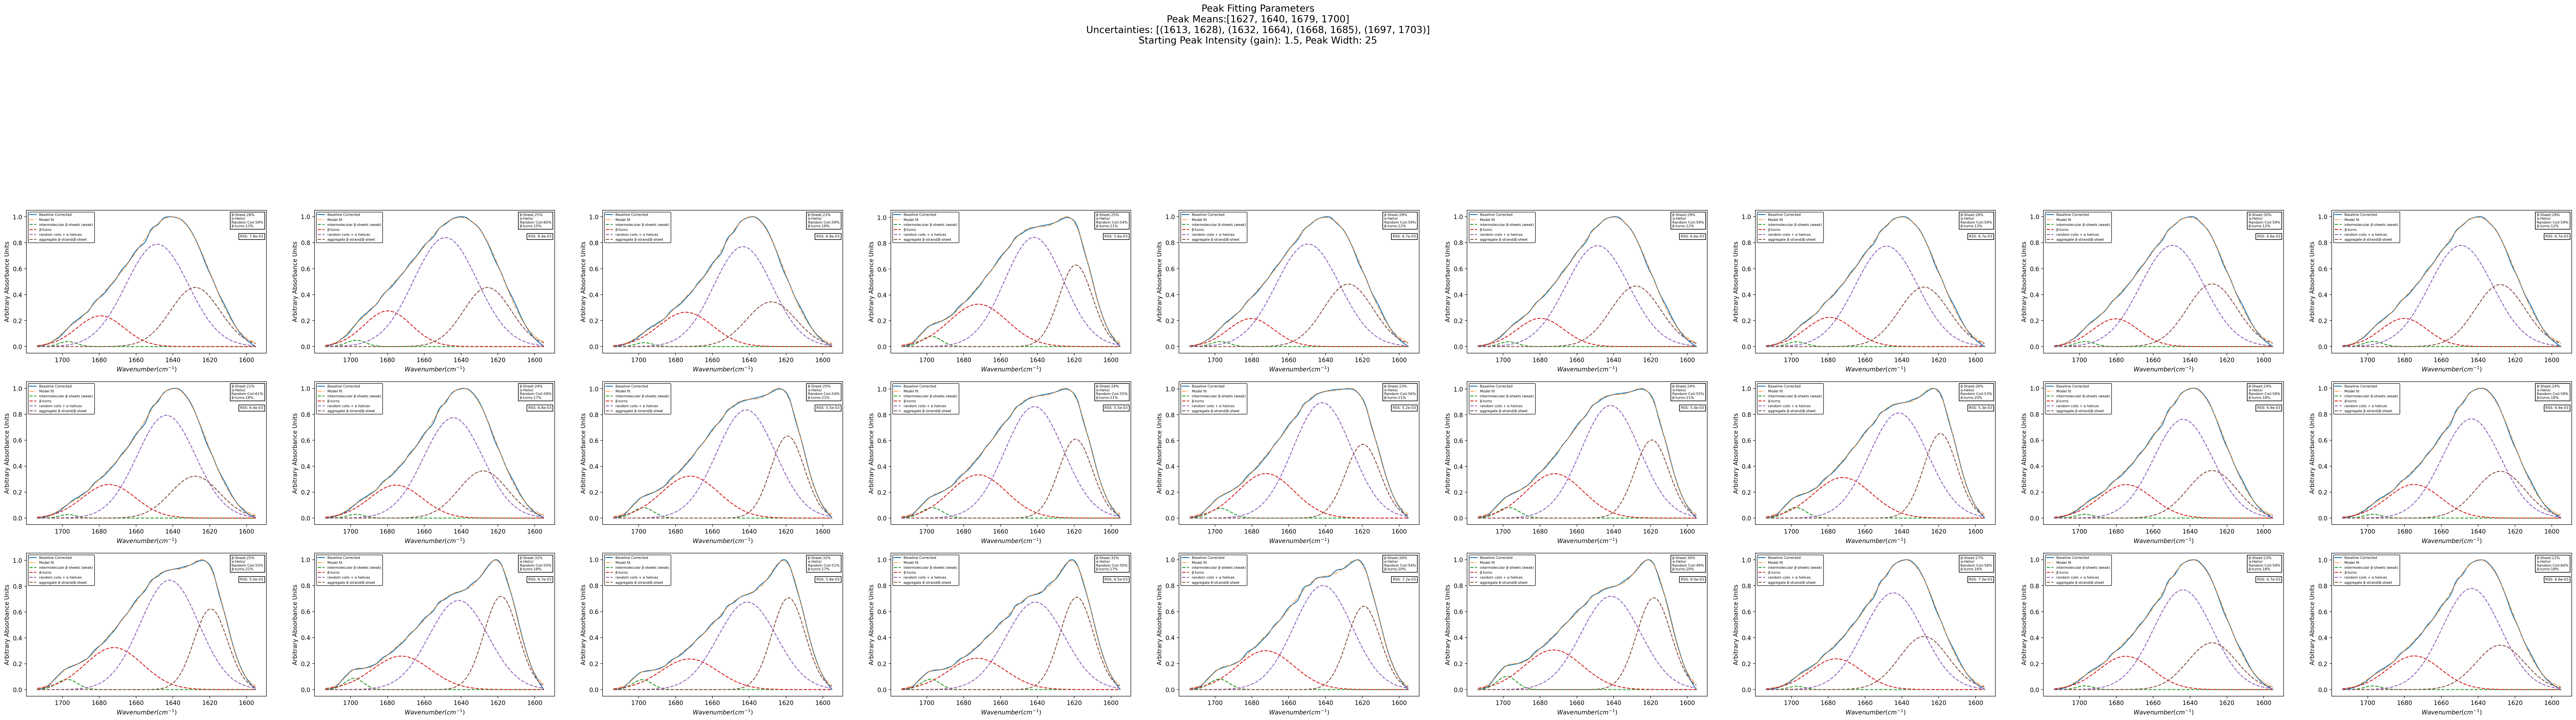

In [62]:
# Jeff 8/25/2022: attempt to redo this portion more simply. Import it as is, and if the file is an image from the microscope (multiple spectra in one file), then flip it
reluncert = 5
gainnum = 1.5 #gain, was originally 0.95

#  Approach: make a grid as it is pulled forom non-flattened indices so that I can more easily think about the math for propper placement of "pixels"; from above, the plots start at top left, but
# should actually start at bottom left. Need to confirm if the grid is started from another corner whether the FT-IR starts measuring from another corner, and then possibly put another gui to allow 
# users to select which corner data collection starts in

#try variable peak width input
pw = 25 #peak width 30cm^-1 from "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"

peakfitlibname = 'four_peak'
peaksfittinglib = four_peak 

from matplotlib.offsetbox import AnchoredText


fig, axs = plt.subplots(num_in_y,num_in_x, figsize=(num_in_x*8.5,num_in_y*5),dpi=200)
titletext  = ('Peak Fitting Parameters' + '\n' + 'Peak Means:' + str(peaksfittinglib['means']) +"\n" + 'Uncertainties: ' + str(peaksfittinglib['uncertainties']) + 
    "\n" + 'Starting Peak Intensity (gain): ' + str(gainnum) + ', Peak Width: ' + str(pw))
#plt.title('Mean WRFv3.5 LHF', fontsize=40)
fig.suptitle(titletext, fontsize=16,y=1.20, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)


structs =[]
gaussian_data = []
secondary_structs_df = pd.DataFrame()

for j in range(0,num_in_y):
    for i in range(0,num_in_x):     

        indexnum=(num_in_x)*(num_in_y-(j+1))+i #this should convert current index to the correct index from the original "linear" dataset 
        #since the data point table doesn't have any location information
        # need to confirm that if data collection starts in another corner other than lower left (upper right, lower right, etc.), 
        # that this doesn't require a different re-indexing operation
        sample = baseline_corrected_AmideI[indexnum].columns[1]
        area, res = gaussian_least_squares(baseline_corrected_AmideI[indexnum], 
                                        baseline_corrected_AmideI[indexnum].columns[1], peak_width=pw, 
                                        peaks=peaksfittinglib, params={'loss':'linear'}) 
        structs.append(secondary_structure(area, peaksfittinglib)) #secondary_structure() returns dict-> make a dataframe? Jeff 8.25
        gaussian_list_data = gaussian_list(baseline_corrected_AmideI[indexnum]['wavenumber'], *res.x)
        gaussian_data.append(gaussian_list_data)
        secondary_structs_df.append(pd.DataFrame.from_dict(structs, orient='columns'))

        #does this math work for crawling through the numbers? maybe this is where I need to apply the logic and put the right data in the right place?
        xdata = baseline_corrected_AmideI[indexnum].iloc[:,0]
        y_fit = sum(gaussian_list_data)
        #probably should have just done this normally and then transposed/flipped the data frame. Maybe next time 

        # index is a bit whack here, need to start from bottom left and starts from top left 
        #      
        # need to modify for running a series of data not from mapping, or running a line (in which case one of the two dimensions are ==1)
        if (num_in_y == 1) or (num_in_x == 1):
            #need to modify this still to work if it's a y-direction sinle line (just need to change index somehow with j and i maybe?)
            axs[i].plot(xdata, baseline_corrected_AmideI[i][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
            # calculate RSS for each spectrum
            resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
            # sum of square residuals - want to minimize this, might need to run some algorithm to do this
            rss = sum(resid*resid)

            #add a dataframe to collect max values
            #maxpeaksforeachcurve_df = []
            
            # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
            
            for k in range(0,len(gaussian_list_data)):
                axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
                label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
                #also label the maximum value for each of the 4 peaks? to do later Jeff 8.25.22
                # #would be something like this:
                # a = list(gaussian_list_data[k])
                # print(xdata[a.index(max(a))])
                # #put them in a df below
                # #maxpeaksforeachcurve_df = []
            axs[i].invert_xaxis()
            legendtext = ['BL Corrected \n Normalized Spectra','Model Fit','intermolecular \n \u03B2-sheet (weak)',
            '\u03B2-turns','random coil + \u03B1-helix','aggregate \u03B2-strand/ \n \u03B2-sheet',]
            legend1 = axs[i].legend(legendtext,loc="upper left",fontsize='small',frameon=True)
            legend1.get_frame().set_edgecolor('k')
            rssTitle = "RSS: "+ str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=8), frameon=True, bbox_to_anchor=(1., 0.8),bbox_transform=axs[i].transAxes)           
            # ratioText = ('\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
            #     structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)'])) +'\n' +'\u03B1-Helix/' + '\n' +'Random Coil:'+ str("{:.0%}".format(structs[num_in_x*j+i]['random coils + \u03B1 helices'] ))+
            #     '\n'+'\u03B2-turns:' + str("{:.0%}".format(structs[num_in_x*j+i]['\u03B2-turns'] )))
            #changed this to be 4 numbers instead of a combined beta sheet and only 3:
            ratioText = ('aggregate \u03B2-strand/\u03B2-sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'])) + '\n'+
                'intermolecular \n \u03B2-sheets (weak):'+ str("{:.0%}".format(structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)'])) +'\n' +'\u03B1-Helix/' + '\n' +'Random Coil:'+ str("{:.0%}".format(structs[num_in_x*j+i]['random coils + \u03B1 helices'] ))+
                '\n'+'\u03B2-turns:' + str("{:.0%}".format(structs[num_in_x*j+i]['\u03B2-turns'] )))
            
            axs[i].add_artist(rssText)
            aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=8), frameon=True)
            axs[i].add_artist(aRatioText)
            #strindexnum= str(indexnum)
            strindexnum= str(baseline_corrected_AmideI[indexnum].columns[1])
            #take out if you want to keep number after .!!!
            strindexnum = strindexnum.split('-')[0]
            plt.setp(axs[:], ylabel='Arbitrary Absorbance Units')
            plt.setp(axs[:], xlabel=r'$Wavenumber (cm^{-1})$')

            #numberinlist = AnchoredText(strindexnum, loc='upper center', prop=dict(size=9),frameon=True)
            axs[i].set_title(strindexnum,fontsize= 10)
            #axs[i].add_artist(numberinlist)        
        else:
            axs[j,i].plot(xdata, baseline_corrected_AmideI[indexnum][sample],label='Baseline Corrected') #Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[j,i].plot(xdata, y_fit, label='Model fit',ls='-.',linewidth=1) 
            # calculate RSS for each spectrum
            resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
            # sum of square residuals - want to minimize this, might need to run some algorithm to do this
            rss = sum(resid*resid)

            # Jeff 5.31.22: Label each of the gaussian curves with the correct type of peak
            for k in range(len(gaussian_list_data)):
                axs[j,i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls='--', 
                label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k])) #label=str(structs[j][1])) #label='')
            axs[j,i].invert_xaxis()
            
            legend1 = axs[j,i].legend(loc="upper left",fontsize='xx-small')
            legend1.get_frame().set_edgecolor('k')
            rssTitle = "RSS: "+ str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(size=6), frameon=True,bbox_to_anchor=(1., 0.85),bbox_transform=axs[j,i].transAxes)           
            ratioText = ('\u03B2-Sheet:'+ str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)'])) +'\n' +'\u03B1-Helix/'+'\n' + 'Random Coil:'+ str("{:.0%}".format(structs[num_in_x*j+i]['random coils + \u03B1 helices'] ))+
                '\n'+'\u03B2-turns:' + str("{:.0%}".format(structs[num_in_x*j+i]['\u03B2-turns'] )))
            axs[j,i].add_artist(rssText)
            aRatioText = AnchoredText(ratioText, loc='upper right', prop=dict(size=6), frameon=True)
            axs[j,i].add_artist(aRatioText)
            #strindexnum= str(indexnum)
            #strindexnum= str(baseline_corrected_AmideI[indexnum].columns[1])
            #numberinlist = AnchoredText(strindexnum, loc='upper right', prop=dict(size=6), frameon=True)
            plt.setp(axs[:], ylabel='Arbitrary Absorbance Units')
            plt.setp(axs[:], xlabel=r'$Wavenumber (cm^{-1})$')
            #axs[j,i].add_artist(numberinlist)

fullfigname = (savefolderpath+'/'+'spectra.png')
plt.savefig(fullfigname)
# don't display here as image will be enormous
#plt.show()

In [55]:
# for j in range(0,len(gaussian_list_data)):    
#     for i in range(0,len(gaussian_data)):
#         a = list(gaussian_data[i][1])
#         #print(a.index(max(a)))
#         print(xdata[a.index(max(a))])
#     print(j)
# #gaussian_list_data[5]

#gaussian_data[0]
structs[0]
#gaussian_list_data

{'intermolecular β-sheets (weak)': 0.008308592814017544,
 'aggregate β-strand/β-sheet': 0.26993868487489175,
 'β-turns': 0.13376555908785284,
 'random coils + α helices': 0.5879871632232379}

Compare % of beta sheet via Seaborn Heatmap

In [12]:
total_beta_percent = []

for i in range(0, len(structs)):
    total_beta_percent.append(
        structs[i]['aggregate \u03B2-strand/\u03B2-sheet'] + structs[i]['intermolecular \u03B2-sheets (weak)'])
#print('type of total_beta_percent:',type(total_beta_percent))
# also make a new dataframe for math later
#total_beta_percent_df = pd.DataFrame(columns = total_beta_percent)

#print('total beta %', total_beta_percent)

# make two DFs, one with all secondary structure values, and then another one with total beta sheet only

secondary_structs_df = pd.DataFrame.from_dict(
    structs, orient='columns')  # columns=rawData_df[2:].columns)
secondary_structs_df = secondary_structs_df.transpose()
secondary_structs_df.columns = rawData_df.columns[1:]
# print(secondary_structs_df)

# for j in range(0,len(structs)):
#     structs_df[j] = pd.DataFrame(list(structs[j].items()), columns=['Structure','Fraction'])
# #structs_df.to_csv('/home/jovyan/ftir_data_analytics/data/fitted_results/'+sample+'.csv', index=False)
# print(structs_df)

total_beta_sheet_df = pd.DataFrame(total_beta_percent, columns = ['TotalBetaSheet%'])
total_beta_sheet_df.index = rawData_df.columns[1:]
#rawData_df.columns[0] = rawData_df.columns['fileheader','total beta_sheet %']

# extractedtime = []
# extractedsamplenumber = []
# for i in range(len(rawData_df.columns[1:])):
#     splitname = rawData_df.columns[1:][i].split("min")
#     extractedtime.append(int(splitname[0]))
#     splitname2 = rawData_df.columns[1:][i].split(".")
#     extractedsamplenumber.append(splitname2[1])
# print(extractedtime)

# total_beta_sheet_df['Minutes'] = extractedtime
# total_beta_sheet_df['SampleNumber'] = extractedsamplenumber
# total_beta_sheet_df = total_beta_sheet_df[['Minutes','SampleNumber','TotalBetaSheet%']]


#print(total_beta_sheet_df)
# #print(total_beta_sheet_df['1hr.0'])
# #print(total_beta_sheet_df['1hr.0']+total_beta_sheet_df['1hr.1'])

# #total_beta_sheet_df[total_beta_sheet_df['Minutes']==5]['TotalBetaSheet%']
# total_beta_sheet_df['TotalBetaSheet%'].plot()
total_beta_percent_60C_df = total_beta_sheet_df
secondary_structs_60C_df = secondary_structs_df


In [13]:
totalbetasavename  = (savefolderpath+'/'+'1D_Total_beta_sheet.csv')
total_beta_sheet_df.to_csv(totalbetasavename, index = False)

#total_beta_sheet_df.to_csv("1D_Total_beta_sheet.csv", index = False)
#total_beta_sheet_df

In [14]:
#looking into beta sheet content
#this only works for labeled DF, so not useful at the moment, though maybe when I use the Opus integration 
# it could be 

#secondary_structs_df[('5min.0')]

#secondary_structs_df.filter(like='10min')

In [15]:
total_beta_percent

[0.27802801625675544,
 0.2546167211345461,
 0.20717716317745974,
 0.2493193917365787,
 0.2904764435104543,
 0.28840145129166683,
 0.28431428017956517,
 0.2955864234378569,
 0.29294377130599536,
 0.21235774396328952,
 0.20638174649195423,
 0.25298112276323503,
 0.2439685341017443,
 0.23104595692353183,
 0.24035373122775286,
 0.2631610233674472,
 0.24045335944678178,
 0.2037244821641651,
 0.24913669553700027,
 0.3198558431274154,
 0.32065395374933353,
 0.3227131157858328,
 0.26458500033049553,
 0.30371651476366107,
 0.2657832614577547,
 0.20863016963938966,
 0.2058957422279602]

In [16]:
#Split up points into x by y grid
break_total_beta_percent = np.array_split(np.array(total_beta_percent),num_in_y)


NameError: name 'Modded_total_beta_sheet_df' is not defined

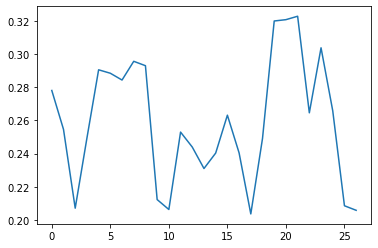

In [17]:
# 2D plot just in case it's useful
plt.plot(total_beta_percent)
fullfigname = (savefolderpath+'/'+'1-D.png')
plt.savefig(fullfigname)

plt.plot(Modded_total_beta_sheet_df)

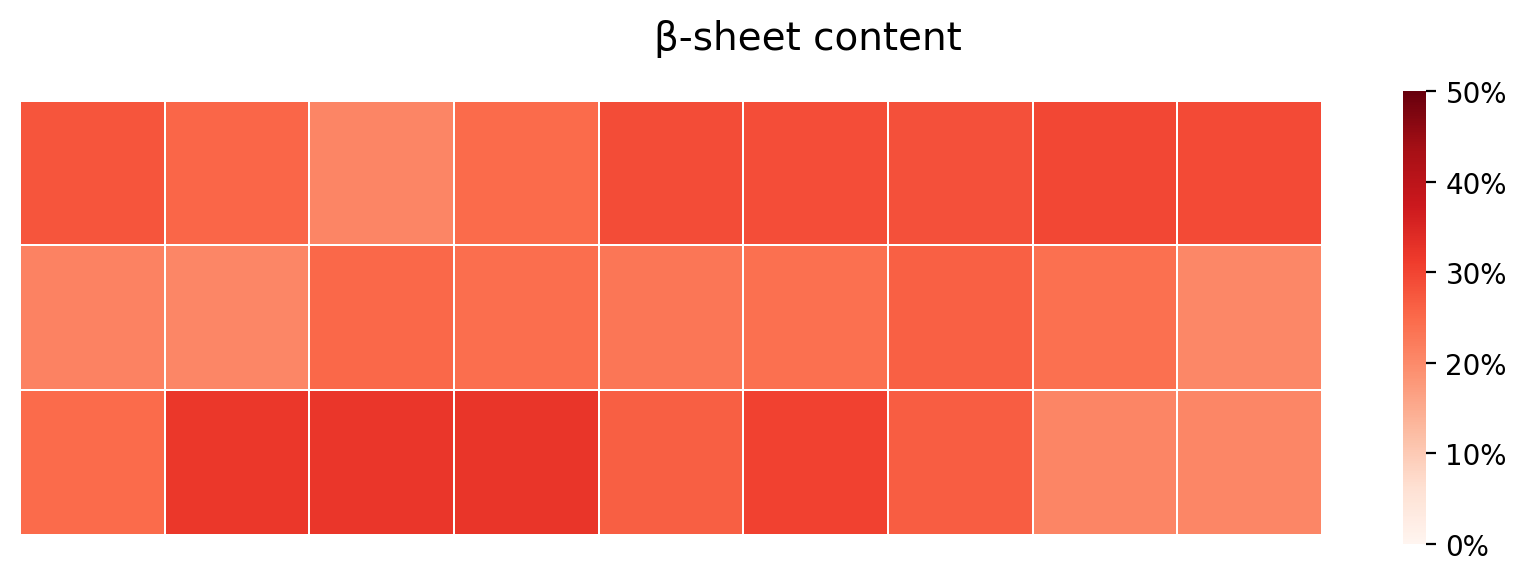

In [18]:
#heatmap via seaborn, plotted from 0 to 50% beta sheet content:
plt.figure(figsize = (num_in_x + 1.5,num_in_y),dpi=200)

#save beta sheet content into csv; if from single microscopy file, use the shape of the data as it is; if it's from multiple files, save it with the header
fullcsvname = (savefolderpath+'/'+'Total_betasheet_Array.csv')
np.savetxt(fullcsvname, break_total_beta_percent, fmt='%.4f',delimiter=',')

hmtitletext  = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds",vmin=0, vmax=0.5, linewidths=.05, xticklabels=False, yticklabels=False,square=True)
plt.suptitle(hmtitletext , fontsize=14,y=1, va='top', ha = 'center')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0,0.1,0.2,0.3,.4,.5])
cbar.set_ticklabels(['0%','10%', '20%', '30%', '40%','50%'])

#save heatmap into file
fullfigname = (savefolderpath+'/'+ os.path.basename(filenamevar[0]) +'_Heatmap_0to50Scale.png')
plt.savefig(fullfigname)

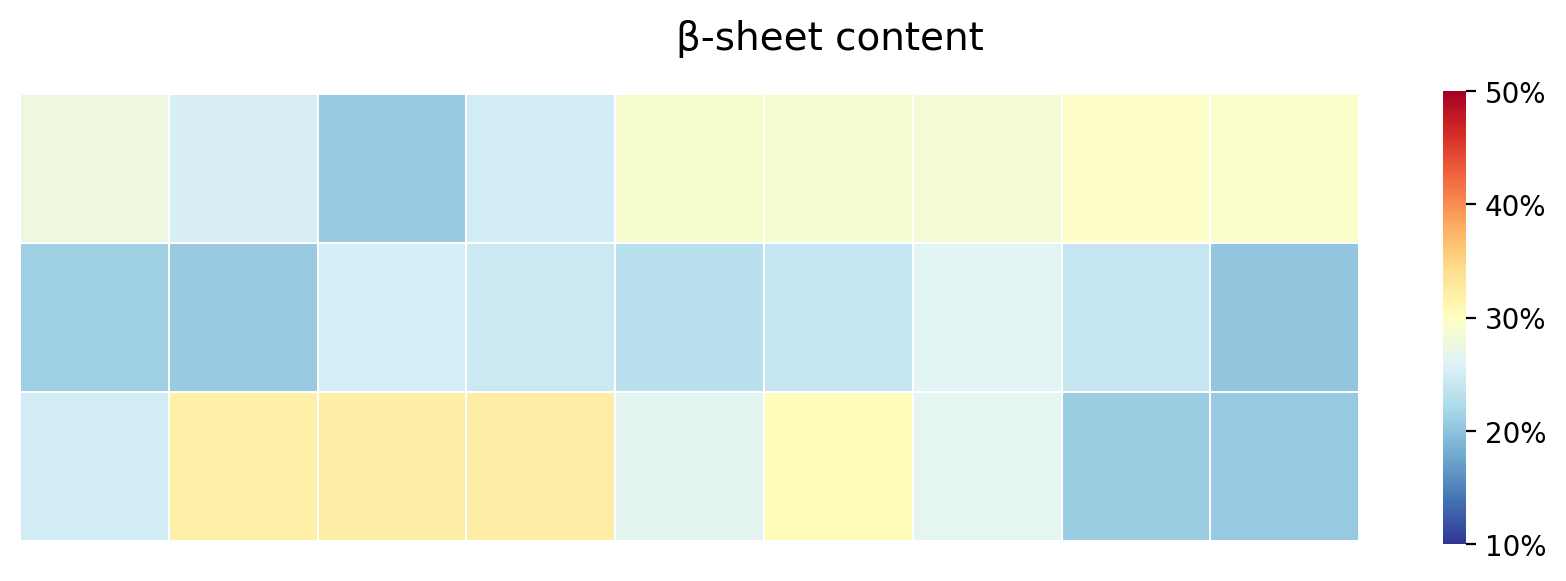

In [19]:
#heatmap via seaborn, plotted from 10 to 50% beta sheet content blue to yellow to red:
plt.figure(figsize = (num_in_x*1.2,num_in_y),dpi=200)

hmtitletext  = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)],cmap="RdYlBu_r", vmin=0.10, vmax=0.5, linewidths=.05, 
square = True, xticklabels=False, yticklabels=False) 
#sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
plt.suptitle(hmtitletext , fontsize=14,y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0.1,0.2,0.3,.4,.5])
cbar.set_ticklabels(['10%', '20%', '30%', '40%','50%'])

fullfigname = (savefolderpath+'/'+'HeatmapBlueYellowRed10to50.png')
plt.savefig(fullfigname)

vmin 0.2
vmax 0.4
l [0.2 0.3 0.4]
l1 ['20.0', '30.0', '40.0']


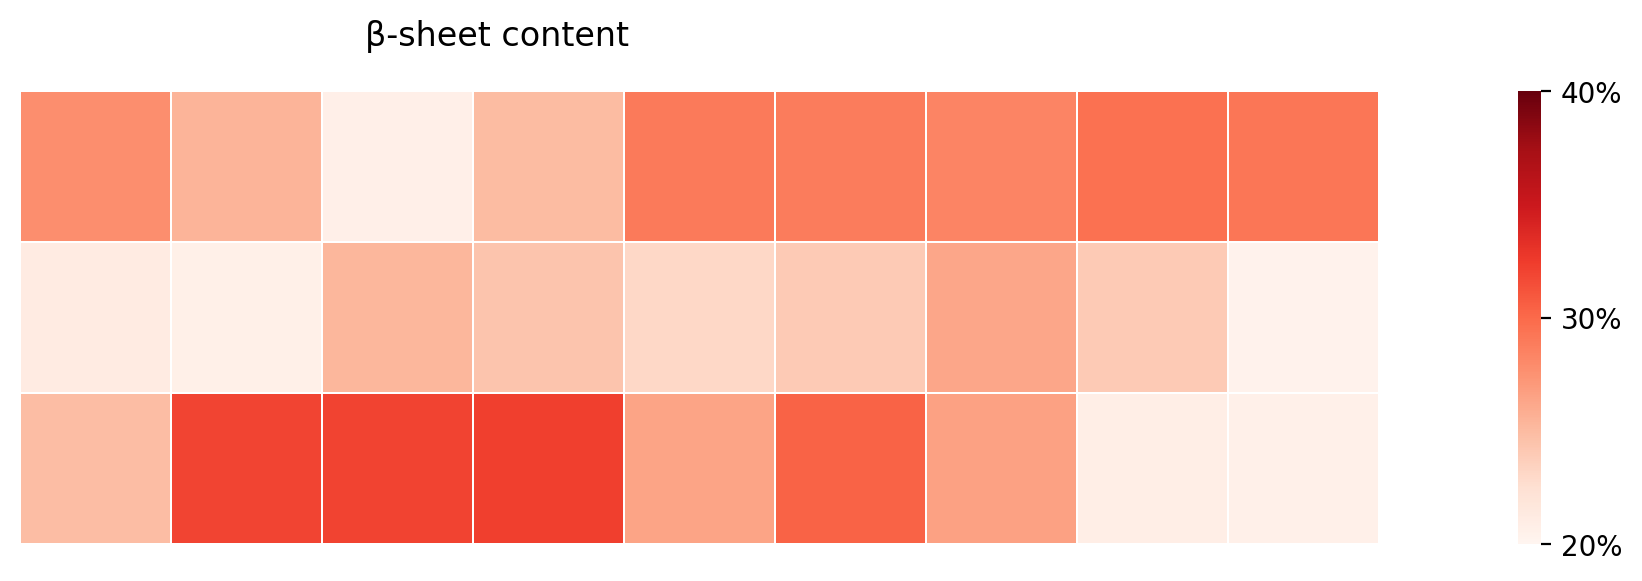

In [20]:
#heatmap via seaborn with automatically changing intensity axis
import math
plt.figure(figsize = (num_in_x*2,num_in_y),dpi=200)

#generate mininum and maximum values for colorscale by rounding to the nearest "10", then going down for min and up for max
vminimum = math.floor(min(total_beta_percent)*10)/10
print('vmin', vminimum)
vmaximum = math.ceil(max(total_beta_percent)*10)/10
print('vmax',vmaximum)
hmtitletext  = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds",vmin=vminimum, vmax=vmaximum, linewidths=.05, 
xticklabels=False, yticklabels=False, square=True)
plt.suptitle(hmtitletext , fontsize=12,y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.365)

# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
l = np.arange(vminimum,vmaximum+.1,0.1)
print('l', l)
l1 = ["%.1f" % member for member in l*100]
print('l1', l1)
cbar.set_ticks(l)
l2 =  ["%.0f" % member for member in l*100]
l3 =list(map("{}%".format,l2))
cbar.set_ticklabels(l3)

#save heatmap into file
fullfigname = (savefolderpath+'/'+'HeatmapWhitetoRedAutoFitScalebar.png')
plt.savefig(fullfigname)

#Statistics

In [26]:
#crreate Mean, 
#total_beta_sheet_df['5min.0']

In [27]:
# #plot beta sheet concentration vs time
# fig, ax = plt.subplots(figsize=(20, 10),constrained_layout=True) 

# titletext  = ('\u03B2-sheet content vs Water Annealing Temperature and Time')
# fig.suptitle(titletext, fontsize=16,y=1.05, va='top')
# ax.plot(total_beta_sheet_df.columns,total_beta_percent,label='60C')

# plt.show()

In [ ]:
#@ Setting up some statistics tests that aren't relavent rn for this script
# list_total_beta_sheet= []
# list_AHRC=[]
# list_beta_turn = []
# for i in range(len(structs)):
#     list_total_beta_sheet.append(structs[i]['aggregate \u03B2-strand/\u03B2-sheet']+structs[i]['intermolecular \u03B2-sheets (weak)'])
#     list_AHRC.append(structs[i]['random coils + \u03B1 helices'])
#     list_beta_turn.append(structs[i]['\u03B2-turns'])
# #list_total_beta_sheet[:]


# edge_list = ['MeOH No UV']*3
# inside_list = ['MeOH then 10hrUV']*3
# condition_list = [*edge_list,*inside_list]#inside_list.extend(outside_list)

# combinedConditionBetadict = {'Condition':condition_list,'total beta-sheet': list_total_beta_sheet}
# combinedConditionRCAHdict = {'Condition':condition_list,'random coil/alpha helix': list_AHRC} 
# combinedConditionBetaTurndict = {'Condition':condition_list,'beta-turn': list_beta_turn}

# df_of_total_beta_sheet = pd.DataFrame(combinedConditionBetadict)
# df_of_AHRC = pd.DataFrame(combinedConditionRCAHdict)
# df_of_beta_turn = pd.DataFrame(combinedConditionBetaTurndict)
# #combinedConditionBetadict

In [ ]:
# # Make a paired t-test (or ANOVA 1 way + bonferonni correction plots for multiple comparisons) with p-value/significance displayed for total beta sheet
# import string
# import seaborn as sns
# sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
# sns.set_style("white")
# from statannot import add_stat_annotation
# import matplotlib.ticker as mtick

# order = ['MeOH No UV','MeOH then 10hrUV']
# box_pairs = [('MeOH No UV','MeOH then 10hrUV')]
# #beta sheet total
# ax = sns.boxplot(data =df_of_total_beta_sheet, x =df_of_total_beta_sheet['Condition'],
# y = df_of_total_beta_sheet["total beta-sheet"],order=order,color=None ,palette=None,linewidth=None)

# testresults = add_stat_annotation(ax, x = df_of_total_beta_sheet['Condition'],
# y = df_of_total_beta_sheet["total beta-sheet"],test='t-test_ind', text_format='star', 
# loc='outside', verbose=2, box_pairs = box_pairs, comparisons_correction =None,
# order = order)

# StatsText = AnchoredText('test',loc='upper right', prop=dict(size=6), frameon=True)
# # ax.add_artist(StatsText)
# # Titletext  = ('p-value')
# # #plt.title('Mean WRFv3.5 LHF', fontsize=40)
# # fig.suptitle(titletext, fontsize=18,y=1.15, va='top')

# import scipy.stats
# # F,p = scipy.stats.f_oneway(df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='37C WA']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='As Dried']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='MeOH Immersion']['total beta-sheet'])

# #ax.set_xlabel('200nm Spuncoat Film Treatment, n=3 per treatment' +'\n'+str(testresults))
# #ax.set_xlabel('Film Treatment, n=6 per treatment' +'\n'+"1-Way ANOVA P value:" + "{:.2e}".format(p))  #+ '\n' +"Groups compared with 1 way pairwise T-test with Bonferroni correction:"+
# # '\n'+  "37C WA vs As Dried:  \u03B1 0.05"+'\n'+"37C WA vs As Dried: asdf \u03B1 0.05"+'\n' +"37C WA vs As Dried: asdf \u03B1 0.05")
# # #ax.ylabel('%', fontweight ='bold', fontsize = 15)

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
# plt.show()
# testresults